In [1]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import pyproj
from tqdm import tqdm
import numpy as np

In [2]:
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [4]:
# check python version and all packages version
def check_python_version():
    import sys
    print("Python version")
    print (sys.version)
    print("Pandas version")
    print(pd.__version__)
    print("Geopandas version")
    print(gpd.__version__)
    print("Xarray version")
    print(xr.__version__)
    print("Pyproj version")
    print(pyproj.__version__)

check_python_version()

Python version
3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pandas version
2.2.2
Geopandas version
0.14.2
Xarray version
2023.6.0
Pyproj version
3.6.1


In [30]:
#file_path = '../Vegetation_Data/veg_mapping.csv'
# read the csv file
#veg_mapping = pd.read_csv(file_path, header=None)
#cols = ['veg_code', 'veg_type']

In [32]:
#veg_mapping

,0,1
0,1,Agriculture - low
1,2,Agriculture - rarely
2,3,Barren - rarely
3,4,Native Chapparal - archetypical
4,5,Native Chapparal - fire
5,6,Native Coastal Sage Scrub - archetypical
6,7,Native Coastal Sage Scrub - fire
7,8,Native Coastal Sage Scrub - mesic
8,9,Native Conifer Alpine - fire
9,10,Native Conifer Alpine - low


In [5]:
fire_label = pd.read_parquet('../Clean_Data/fire_label_data.parquet')

In [6]:
fire_label.shape

(134548841, 4)

In [7]:
fire_label.dtypes

lon               float64
lat               float64
day        datetime64[ns]
IS_FIRE             int32
dtype: object

In [7]:
fire_label.head()

,lon,lat,day,IS_FIRE
0,-124.391667,40.441667,2001-01-01,0
1,-124.391667,40.441667,2001-01-02,0
2,-124.391667,40.441667,2001-01-03,0
3,-124.391667,40.441667,2001-01-04,0
4,-124.391667,40.441667,2001-01-05,0


In [8]:
fire_label_2023 = fire_label[fire_label['day'] > '2023-01-01']
fire_label_2023.shape

(5834976, 4)

In [10]:
# write the data to parquet file
fire_label_2023.to_parquet('../Clean_Data/Model_Data/fire_label_data_2023_OOT.parquet')

In [8]:
# extract year, month, day, hour from the day column
fire_label['month'] = fire_label['day'].dt.month

In [9]:
# group by month, sum IS_FIRE
fire_label_month = fire_label.groupby(['month']).agg({'IS_FIRE': 'sum'}).reset_index()

In [42]:
fire_label_month

,month,IS_FIRE
0,1,87
1,2,68
2,3,85
3,4,173
4,5,489
5,6,1188
6,7,1530
7,8,1240
8,9,861
9,10,440


In [10]:
fire_1 = fire_label[fire_label['IS_FIRE'] == 1]
fire_0 = fire_label[fire_label['IS_FIRE'] == 0]

In [44]:
fire_1.shape

(6428, 6)

In [11]:
# remove month = 1, 2, 3, 4 for fire_0
print(fire_0.shape)
fire_0 = fire_0[fire_0['month'] > 4]
print(fire_0.shape)

(134542413, 5)
(90228205, 5)


In [12]:
# downsample fire_0 to the same size as fire_1*100, set seed to 0
fire_0_downsample = fire_0.sample(n=fire_1.shape[0]*100, random_state=0)

In [13]:
fire_0_downsample.shape

(642800, 5)

In [14]:
# combine fire_1 and fire_0_downsample
fire_label_downsample = pd.concat([fire_1, fire_0_downsample])
# save the downsampled data
fire_label_downsample.to_parquet('../Clean_Data/Model_Data/fire_label_downsample.parquet')

In [15]:
fire_label_downsample.head()

,lon,lat,day,IS_FIRE,month
164175,-124.308333,40.233333,2013-07-12,1,7
203998,-124.266667,40.316667,2007-07-27,1,7
228923,-124.266667,40.191667,2007-10-25,1,10
230275,-124.266667,40.191667,2011-07-08,1,7
230695,-124.266667,40.191667,2012-08-31,1,8


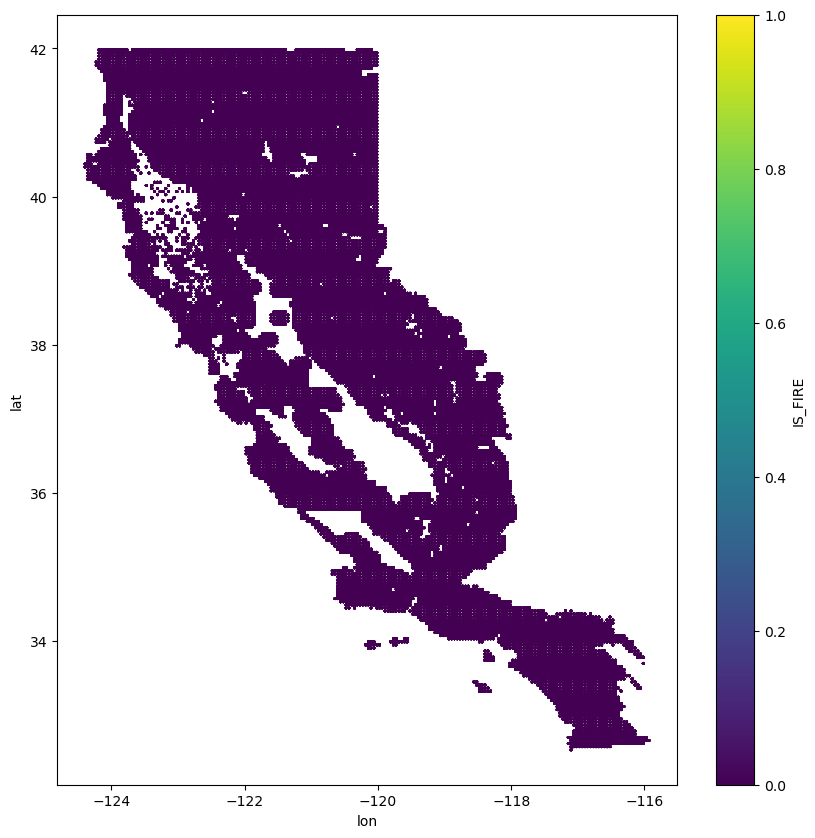

In [52]:
# plot the vegetation_dat
fire_label_downsample.plot(kind='scatter', x='lon', y='lat', c='IS_FIRE', cmap='viridis', s=1, figsize=(10, 10))
plt.show()